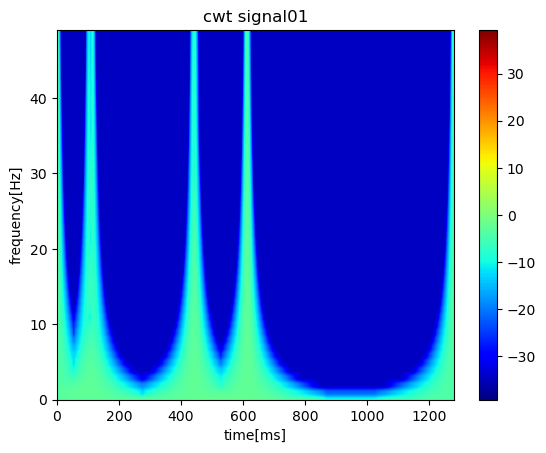

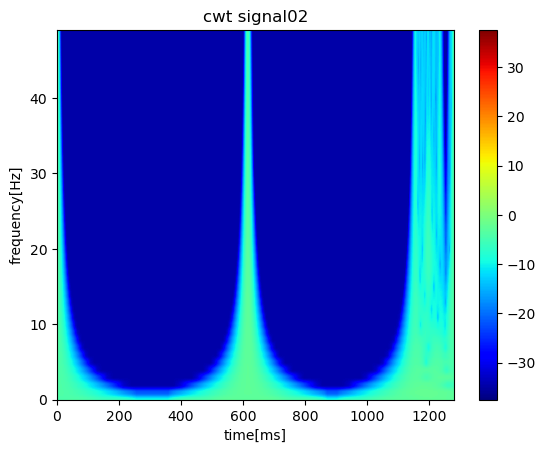

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import utills.datapath as dpath
from cutill.x64.Release import cutill as c

width = 6

# マザーウェーブレット：モルレーウェーブレット
def morlet(x, f, width):
    sf = f / width
    st = 1 / (2 * math.pi * sf)
    A = 1 / (st * math.sqrt(2 * math.pi))
    h = -np.power(x, 2) / (2 * st**2)
    co1 = 1j * 2 * math.pi * f * x
    return A * np.exp(co1) * np.exp(h)

# 連続ウェーブレット変換
def mycwt(Fs, data, fmax, wavelet_R=2):
    # Fs:           サンプリング周波数
    # data:         信号
    # wavelet_R:    マザーウェーブレットの長さ(秒)
    # fmax:         解析する最大周波数

    Ts = 1 / Fs     # サンプリング時間幅
    data_length = len(data) # 信号のサンプル数を取得
    
    # マザーウェーブレットの範囲
    wavelet_length = np.arange(-wavelet_R, wavelet_R, Ts)

    # 連続ウェーブレット変換後のデータを格納する配列の作成
    wn = np.zeros([fmax, data_length])

    # 連続ウェーブレット変換の実行
    for i in range(0, fmax):
        wn[i,:] = np.abs(np.convolve(data, morlet(wavelet_length, i+1, width), mode='same'))
        wn[i,:] = np.log((2 * wn[i, :] / Fs)**2)
    
    return wn

# 連続ウェーブレット変換後のカラーマップ作成関数
def cwt_plot(CWT, sample_time, fmax, fig_title):
    plt.imshow(CWT, cmap='jet', aspect='auto',vmax=abs(CWT).max(), vmin=-abs(CWT).max())  
    plt.title(fig_title)
    plt.xlabel("time[ms]")
    plt.ylabel("frequency[Hz]")
    plt.axis([0, len(sample_time), 0, fmax-1])
    plt.colorbar()

# ======================================================================= # 
# 被験者データ
tester = dpath.LMH.M002.value.st_center

# pandasでcsvを読み込み
wave = pd.read_csv(".."/tester.value/"wave.csv", names=["L", "R", "L_gain", "R_gain"])
posture = pd.read_csv(".."/tester.value/"position.csv")

lraw = wave['L'].to_numpy()
rraw = wave['R'].to_numpy()
lgain = wave['L_gain'].to_numpy()
rgain = wave['R_gain'].to_numpy()
posture = posture.to_numpy()

left = lraw * 2.818 ** lgain
right = rraw * 2.818 ** rgain

start = 0
end = start + 10

left_part = left[128*start:128*end]
right_part = right[128*start:128*end]

left_part, right_part = c.normalize(left_part, right_part)


if __name__ == "__main__":
    signal01 = left_part
    signal02 = right_part

    # 信号作成 ----------------------------------------
    Fs = 128 # サンプリング周波数
    Ts = 1 / Fs # 1ステップあたりの時間幅
    time_S = 10 # 信号は5秒分
    t_data = np.arange(0, time_S, Ts)

    # 連続ウェーブレット変換 ----------------------------------------
    fmax=50 # 解析する最大周波数
    cwt_signal01 = mycwt(Fs=Fs, data=signal01, fmax=fmax)
    cwt_signal02 = mycwt(Fs=Fs, data=signal02, fmax=fmax)

    plt.figure(5) # signal01を連続ウェーブレット変換した時のカラーマップの図
    fig_title01 = "cwt signal01"
    cwt_plot(cwt_signal01, t_data, fmax, fig_title01)

    plt.figure(6) # signal02を連続ウェーブレット変換した時のカラーマップの図
    fig_title02 = "cwt signal02"
    cwt_plot(cwt_signal02, t_data, fmax, fig_title02)
    
    plt.show()